<a href="https://colab.research.google.com/github/hendrikaang/Banana-Ripness-Classification-Using-CNN/blob/main/Banana_ripness_classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2018 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Banana Ripeness Classification
Di dalam program ini, kita akan menggunakan metode Convolutional Neural Network(CNN) untuk mengklasifikasikan tingkat kematangan buah pisang.

Program dibagi menjadi 3 bagian:
1. Eksplorasi sampel data
2. Membangun CNN
3. Evaluasi akurasi pada data training dan data validasi

## Eksplorasi sampel data

Pertama, siapkan dulu direktori kerjanya dengan memasukkan dataset yang terdiri dari pisang matang dan pisang busuk ke dalam drive.

Berikutnya masukkan path drive letak dataset pada kolom yang disediakan.

**NOTE** Dataset berupa kumpulan gambar pisang didapatkan dari [Fruits fresh and rotten for classification dataset](https://www.kaggle.com/sriramr/fruits-fresh-and-rotten-for-classification)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Menyiapkan direktori kerja
import os

# Masukkan path dataset di bawah ini
path = "/content/drive/MyDrive/Kuliah/Smt 6/PCD/Projek Tugas Akhir PCD/Dataset"

os.chdir(path)
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1bYDXtB_gPJovfkHMaDsZC80R5qQlkicO/Dataset'

In [ ]:
# import library
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pywt.data
from google.colab.patches import cv2_imshow

In [ ]:
# Read gambar 

train_dir = os.path.join(path, 'train')
test_dir = os.path.join(path, 'test')

# Directory training fresh banana pictures
train_fresh_dir = os.path.join(train_dir, 'freshbanana')

# Directory training rotten banana pictures
train_rot_dir = os.path.join(train_dir, 'rottenbanana')

# Directory testing fresh banana pictures
test_fresh_dir = os.path.join(test_dir, 'freshbanana')

# Directory testing rotten banana pictures
test_rot_dir = os.path.join(test_dir, 'rottenbanana')

In [ ]:
# Cek nama file

train_fresh_fnames = os.listdir(train_fresh_dir)
print(train_fresh_fnames[:10])

train_rot_fnames = os.listdir(train_rot_dir)
train_rot_fnames.sort()
print(train_rot_fnames[:10])

['rotated_by_45_Screen Shot 2018-06-12 at 9.46.55 PM.png', 'rotated_by_60_Screen Shot 2018-06-12 at 10.02.01 PM.png', 'rotated_by_45_Screen Shot 2018-06-12 at 9.47.22 PM.png', 'rotated_by_45_Screen Shot 2018-06-12 at 9.51.54 PM.png', 'rotated_by_60_Screen Shot 2018-06-12 at 9.39.17 PM.png', 'rotated_by_60_Screen Shot 2018-06-12 at 9.38.38 PM.png', 'rotated_by_45_Screen Shot 2018-06-12 at 9.50.31 PM.png', 'rotated_by_60_Screen Shot 2018-06-12 at 9.39.47 PM.png', 'rotated_by_45_Screen Shot 2018-06-12 at 9.49.37 PM.png', 'rotated_by_45_Screen Shot 2018-06-12 at 9.47.00 PM.png']
['Screen Shot 2018-06-12 at 8.47.14 PM.png', 'Screen Shot 2018-06-12 at 8.47.28 PM.png', 'Screen Shot 2018-06-12 at 8.47.57 PM.png', 'Screen Shot 2018-06-12 at 8.48.07 PM.png', 'Screen Shot 2018-06-12 at 8.48.18 PM.png', 'Screen Shot 2018-06-12 at 8.48.24 PM.png', 'Screen Shot 2018-06-12 at 8.48.32 PM.png', 'Screen Shot 2018-06-12 at 8.48.46 PM.png', 'Screen Shot 2018-06-12 at 8.49.04 PM.png', 'Screen Shot 2018-06-

In [ ]:
# Menghitung banyak file input

print('total training fresh banana images:', len(os.listdir(train_fresh_dir)))
print('total training rotten banana images:', len(os.listdir(train_rot_dir)))
print('total testing fresh banana images:', len(os.listdir(test_fresh_dir)))
print('total testing rotten banana images:', len(os.listdir(test_rot_dir)))

total training fresh banana images: 1581
total training rotten banana images: 2224
total testing fresh banana images: 381
total testing rotten banana images: 530


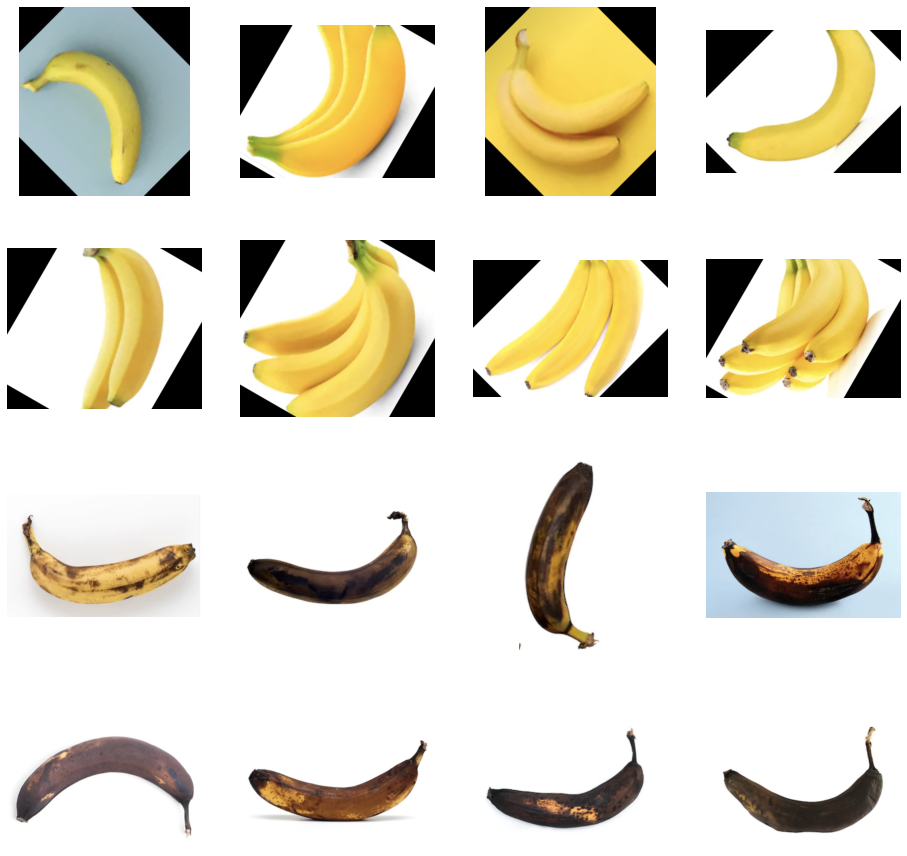

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Menampilkan sampel pisang matang dan pisang busuk
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_banana_pix = [os.path.join(train_fresh_dir, fname) 
                for fname in train_fresh_fnames[pic_index-8:pic_index]]
next_banana_rot_pix = [os.path.join(train_rot_dir, fname) 
                for fname in train_rot_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_banana_pix+next_banana_rot_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## 2. Membangun CNN

Arsitektur CNN yang akan dibangun terdiri dari:
1. layer input
2. 3 layer convolution & pooling
3. fully connected layer

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0   

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 3805 images belonging to 2 classes.
Found 911 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=118,  # 2000 images = batch_size * steps 3805| 20*190 |32*118
      epochs=15,
      validation_data=validation_generator,
      validation_steps=28,  # 1000 images = batch_size * steps 911 | 20*45  |32*28
      verbose=2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
118/118 - 1187s - loss: 0.3246 - acc: 0.8794 - val_loss: 0.0502 - val_acc: 0.9866
Epoch 2/15
118/118 - 112s - loss: 0.0841 - acc: 0.9756 - val_loss: 0.0371 - val_acc: 0.9911
Epoch 3/15
118/118 - 113s - loss: 0.0933 - acc: 0.9807 - val_loss: 0.0220 - val_acc: 0.9922
Epoch 4/15
118/118 - 114s - loss: 0.0494 - acc: 0.9867 - val_loss: 0.4012 - val_acc: 0.8917
Epoch 5/15
118/118 - 112s - loss: 0.0717 - acc: 0.9825 - val_loss: 0.0154 - val_acc: 0.9933
Epoch 6/15
118/118 - 115s - loss: 0.0409 - acc: 0.9915 - val_loss: 0.0105 - val_acc: 0.9967
Epoch 7/15
118/118 - 113s - loss: 0.0518 - acc: 0.9923 - val_loss: 0.0133 - val_acc: 0.9955
Epoch 8/15
118/118 - 112s - loss: 0.0652 - acc: 0.9923 - val_loss: 0.0078 - val_acc: 0.9955
Epoch 9/15
118/118 - 112s - loss: 0.1112 - acc: 0.9923 - val_loss: 0.0108 - val_acc: 0.9967
Epoch 10/15
118/118 - 112s - loss: 0.0403 - acc: 0.9931 - val_loss: 0.0024 - val_acc: 0.9989
Epoch 11/15
118/118 - 111s - loss: 0.0599 - acc: 0.9907 - val_loss: 0.0106 - v

/content/drive/MyDrive/Kuliah/Smt 6/PCD/Projek Tugas Akhir PCD/Dataset/train/rottenbanana/Screen Shot 2018-06-12 at 9.11.58 PM.png


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


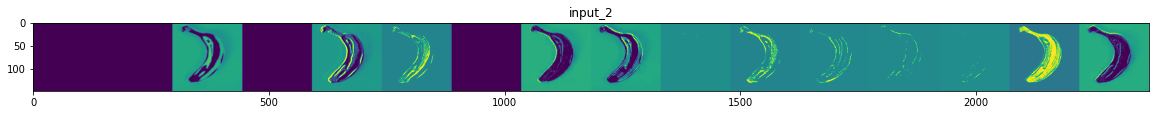

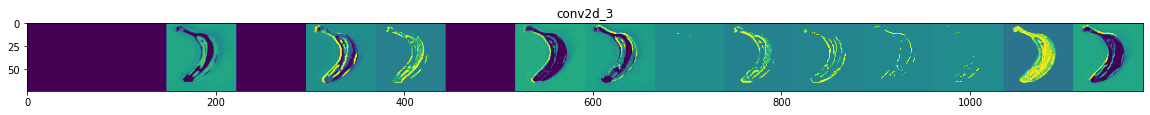

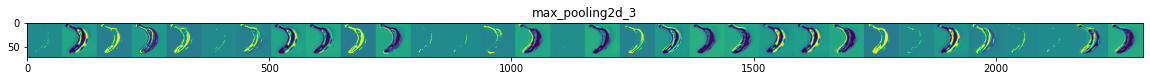

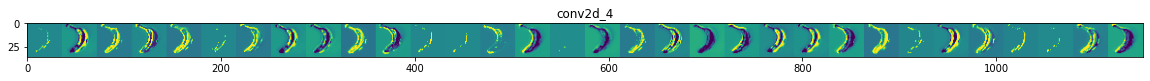

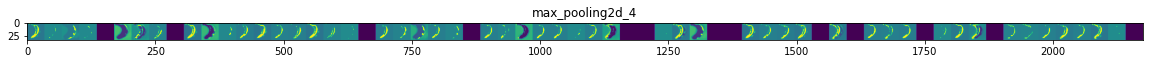

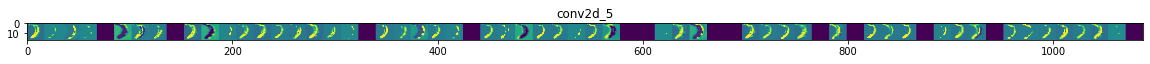

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
fresh_img_files = [os.path.join(train_fresh_dir, f) for f in train_fresh_fnames]
rot_img_files = [os.path.join(train_rot_dir, f) for f in train_rot_fnames]
img_path = random.choice(fresh_img_files + rot_img_files)
print(img_path)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Text(0.5, 1.0, 'Training and validation loss')

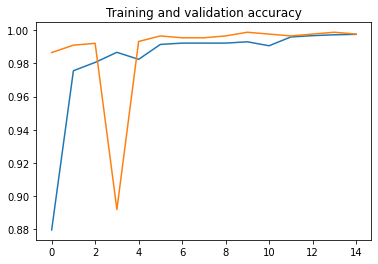

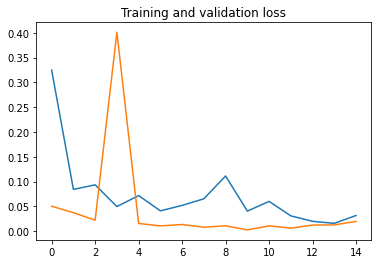

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [ ]:
from keras.preprocessing import image
import numpy as np

img_path='/content/drive/MyDrive/Kuliah/Smt 6/PCD/Projek Tugas Akhir PCD/Dataset/train/freshbanana/rotated_by_60_Screen Shot 2018-06-12 at 9.49.32 PM.png' #fresh ->[[0.]]
#img_path='/content/drive/MyDrive/Kuliah/Smt 6/PCD/Projek Tugas Akhir PCD/Dataset/train/rottenbanana/rotated_by_15_Screen Shot 2018-06-12 at 8.51.38 PM.png'#rotten ->[[1.]]
#img_path='/content/drive/MyDrive/Kuliah/Smt 6/PCD/Projek Tugas Akhir PCD/Dataset/train/rottenbanana/vertical_flip_Screen Shot 2018-06-12 at 9.11.47 PM.png'#salah tebak
img=image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

preds=model.predict(x)
print(preds)

[[0.]]


## Clean Up

Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)